In [87]:
subject_name = 'Linda'

from listen_italian_epoch import listen_italian_epoch
from matplotlib import pyplot as plt
import mne
import os
import numpy as np
import scipy.io
from mne.event import define_target_events
import warnings
warnings.filterwarnings('ignore')

data_path = os.path.dirname(os.path.dirname(os.getcwd()))
raw_fname = data_path + '/analysis/python/data/'+subject_name+'_raw.fif'
raw = mne.io.read_raw_fif(raw_fname,preload=True)

raw_fname = data_path + '/analysis/behaviour/data/subject/'+subject_name+'_behaviour.mat'
mat = scipy.io.loadmat(raw_fname)

Opening raw data file D:\projects\current\listen_italian_motor_entrainment\analysis\python\preprocessing_subjects\Linda_raw.fif...
    Range : 25796 ... 1117847 =     25.796 ...  1117.847 secs
Ready.
Reading 0 ... 1092051  =      0.000 ...  1092.051 secs...


In [88]:
# extract trials of tmax second and remove the wrong answer trials and seperate them in three conditions
Tmin = -0.5
Tmax = 2

epochs = listen_italian_epoch(raw, mat,Tmin, Tmax)
print(epochs)

800 events found
Event IDs: [100 105 106 200]
200 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]
183 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activ

In [89]:
hyper = epochs['hyper'].average()
normal = epochs['normal'].average()
hypo = epochs['hypo'].average()

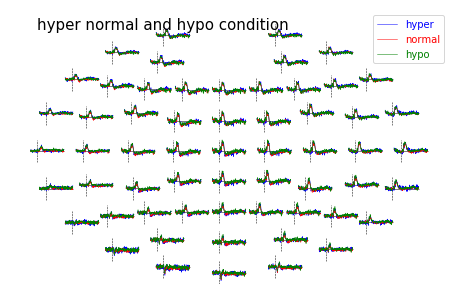

In [90]:
from mne.viz import plot_evoked_topo
# Generate list of evoked objects from conditions names
evokeds = [epochs[name].average() for name in ('hyper', 'normal', 'hypo')]

colors = 'blue', 'red', 'green'
title = 'hyper normal and hypo condition'
plot_evoked_topo(evokeds, color=colors, title=title, background_color='w')
plt.show()

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


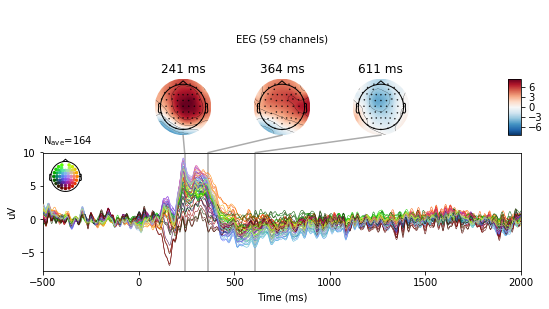

In [91]:
# Then, we construct and plot an unweighted average of left vs. right trials
# this way, too:
a=mne.combine_evoked(evokeds,weights='equal').plot_joint()

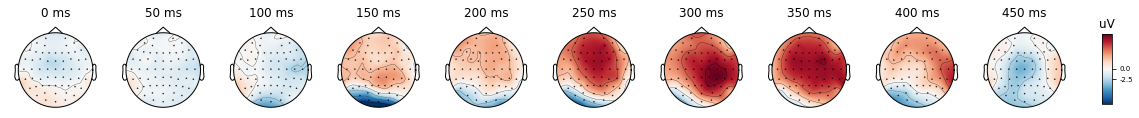

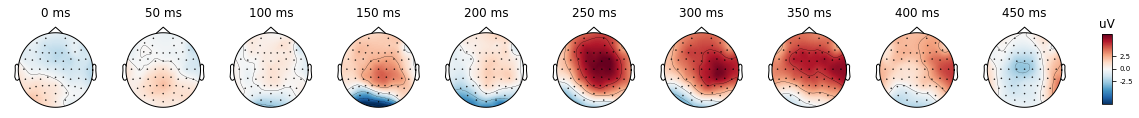

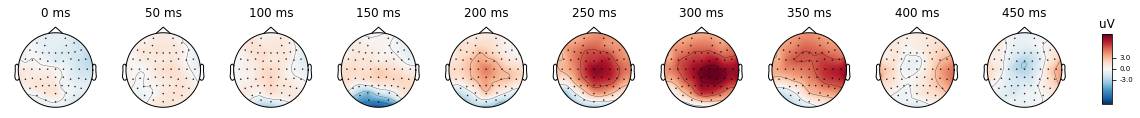

In [92]:
# set time instants in seconds (from 50 to 150ms in a step of 10ms)
times = np.arange(0.0, 0.5, 0.05)
# If times is set to None only 10 regularly spaced topographies will be shown
a=hyper.plot_topomap(times, ch_type='eeg',time_unit='ms')
a=normal.plot_topomap(times, ch_type='eeg',time_unit='ms')
a=hypo.plot_topomap(times, ch_type='eeg',time_unit='ms')


    using multitaper spectrum estimation with 7 DPSS windows


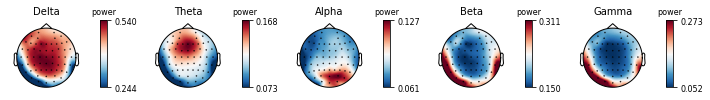

    using multitaper spectrum estimation with 7 DPSS windows


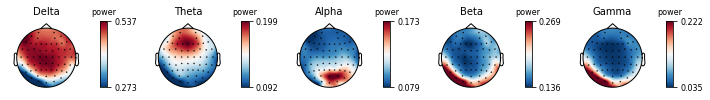

    using multitaper spectrum estimation with 7 DPSS windows


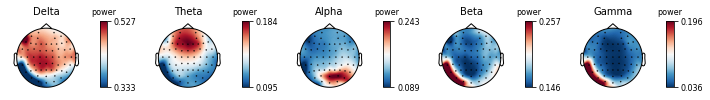

In [93]:
a=epochs['hyper'].plot_psd_topomap(normalize=True)
a=epochs['normal'].plot_psd_topomap(normalize=True)
a=epochs['hypo'].plot_psd_topomap(normalize=True)


In [47]:
from mne.time_frequency import tfr_morlet
# define frequencies of interest (log-spaced)
#freqs = np.logspace(*np.log10([1, 40]), num=20)
freqs = np.arange(1., 40., 2.)
freqs
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,return_itc=True, decim=3, n_jobs=1)

Applying baseline correction (mode: logratio)


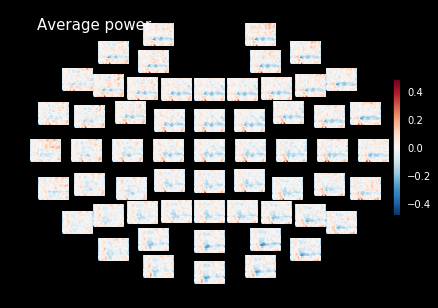

Applying baseline correction (mode: logratio)


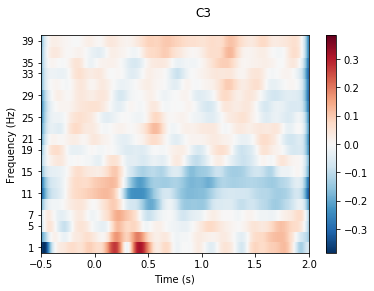

In [48]:
a=power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
a=power.plot([10], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[12])


No baseline correction applied


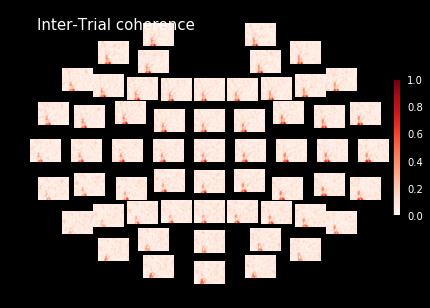

In [49]:
#Inspect ITC
a=itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')

In [52]:
# let's explore some frequency bands
iter_freqs = [
    ('Delta', 1, 3),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 40)
]

# set epoching parameters
Tmin = -0.5
Tmax = 2

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    raw1 = raw.copy()
    # bandpass filter and compute Hilbert
    raw1.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1,  # in each band and skip "auto" option.
               fir_design='firwin')
    raw1.apply_hilbert(n_jobs=1, envelope=False)
    epochs = listen_italian_epoch(raw1, mat,Tmin, Tmax)
    # remove evoked response and get analytic signal (envelope)
    epochs.subtract_evoked()  # for this we need to construct new epochs.
    epochs = mne.EpochsArray(data=np.abs(epochs.get_data()), info=epochs.info, tmin=epochs.tmin)
    # now average and move on
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    

Setting up band-pass filter from 1 - 3 Hz
Filter length of 3301 samples (3.301 sec) selected
800 events found
Event IDs: [100 105 106 200]
200 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]
183 matching events 

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5,0,'Time [ms]')

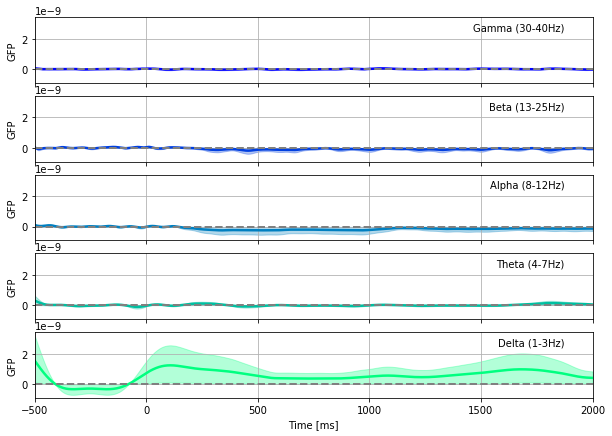

In [53]:
from mne.stats import _bootstrap_ci
from mne.baseline import rescale

fig, axes = plt.subplots(5, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 5))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(Tmin*1000, Tmax*1000)

axes.ravel()[-1].set_xlabel('Time [ms]')